In [312]:
import ezdxf 
import sys
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
from scipy import spatial

In [365]:
try:
    doc = ezdxf.readfile("2horse.dxf")
except IOError:
    print(f"Not a DXF file or a generic I/O error.")
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f"Invalid or corrupted DXF file.")
    sys.exit(2)


In [366]:
class Line:
    def __init__(self, 
                 start: list, 
                 end: list, 
                 id_num,
                 force_2d = True):
        
        self.id = id_num
        self.shape = "line"
        
        if force_2d == True:
            self.start = start[:2]
            self.end = end[:2]
        else:
            self.start = start
            self.end = end
        dy = self.end[1] - self.start[1]
        dx = self.end[0] - self.start[0]
        
        #calculate slope of line
        self.slope = np.angle(complex(dx,dy), True)
            
class Arc: 
    def __init__(self, 
                 center: list, 
                 radius, 
                 start_angle, 
                 end_angle, 
                 start_point: list, 
                 end_point: list,
                id_num):
        
        self.shape = "arc"
        
        self.center = center[:2]
        self.radius = radius
        self.start_angle = start_angle
        self.end_angle = end_angle
        self.start_point = start_point[:2]
        self.end_point = end_point[:2]
        
        self.id = id_num
        
        #calculate slope of end and start points
        
        
        

In [367]:
# helper function
def print_entity(e):
    print("LINE on layer: %s\n" % e.dxf.layer)
    print("start point: %s\n" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)
    
#create network
G = nx.Graph()

# iterate over all entities in modelspace
msp = doc.modelspace()

#saves the actual data. Lines and arcs only.
entities = {"lines": [], "arcs": []}

#iterate over objects
num = 0

#dont change goddamnit
round_precision = 4

for e in msp: 
    
    if e.dxftype() == "LINE":
        
        #round numbers
        start_point = tuple([np.around(pos, round_precision) for pos in e.dxf.start][:2])
        end_point = tuple([np.around(pos, round_precision) for pos in e.dxf.end][:2])
        
        #save points in tuple (hashable type)
        #add point and edge with position saved 
        #print(f"points: {start_point} {end_point}")
        G.add_node(start_point, pos = start_point)
        G.add_node(end_point, pos = end_point)
        G.add_edge(start_point, end_point)
        
        nx.set_edge_attributes(G, {(start_point, end_point): num}, "id")
        entities["lines"].append(Line(start_point, end_point, num))
        num += 1
        
    elif (e.dxftype() == "ARC"):
        #treat arcs the same as lines in the graph
        start_point = tuple([np.around(pos,round_precision) for pos in e.start_point][:2])
        end_point = tuple([np.around(pos, round_precision) for pos in e.end_point][:2])
        
        #print(f"points: {start_point} {end_point}")
        
        G.add_node(start_point, pos = start_point)
        G.add_node(end_point, pos = end_point)
        G.add_edge(start_point, end_point)
        nx.set_edge_attributes(G, {(start_point, end_point): num}, "id")
        
        entities["arcs"].append(Arc(list(e.dxf.center),
                                e.dxf.radius,
                                e.dxf.start_angle,
                                e.dxf.end_angle,
                                list(e.start_point),
                                list(e.end_point),
                                   num))
        num += 1
        
# entity query for all LINE entities in modelspace
#for e in msp.query("LINE"):
    

In [387]:
#get cycles
cycles = nx.cycle_basis(G)

#find notes in a convex outer hull
nodes = list(G)
hull = spatial.ConvexHull(nodes)
outer = []
for index in hull.vertices:
    outer.append(nodes[index])

blacklist = outer[:2] + outer[-2:] #outer <- results in wrong nodes getting flagged
print(blacklist)

index = 0

drawcycle = []
invalids = []

#sort out cycles with nodes in outer regions
for cycle in cycles:
    valid = True
    for point in cycle:
        #print(f"{point}")
        if point in blacklist:
            print(f"cycle {index} invalid")
            valid = False
            break

    if valid == True:
        print(f"cycle {index} valid")
        drawcycle.append(cycle)
    else:
        #save sorted out regions for debugging
        invalids.append(cycle)
    index += 1



[(12.5, 0.0), (65.0, 0.0), (0.0, 65.0), (0.0, 12.5)]
cycle 0 valid
cycle 1 valid
cycle 2 valid
cycle 3 valid
cycle 4 valid
cycle 5 valid
cycle 6 valid
cycle 7 valid
cycle 8 valid
cycle 9 valid
cycle 10 valid
cycle 11 valid
cycle 12 valid
cycle 13 valid
cycle 14 valid
cycle 15 valid
cycle 16 valid
cycle 17 invalid
cycle 18 invalid
cycle 19 invalid


In [398]:
#calculate center of each closed area
#treats arcs as lines
#S = [(x1 + x2 +...), (y1 + y2 +...)] / n

center = {}

for area in drawcycle:
    res = [0, 0]
    for point in area:
        res[0] += point[0]
        res[1] += point[1]
    
    #avg point in shape
    res = [(pos / len(area)) for pos in res]

    #save into dict
    center[tuple(area)] = res

In [396]:
res

[32.032557142857144, 7.3111999999999995]

/tmp/ipykernel_6113/638832807.py:17: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line_obj)


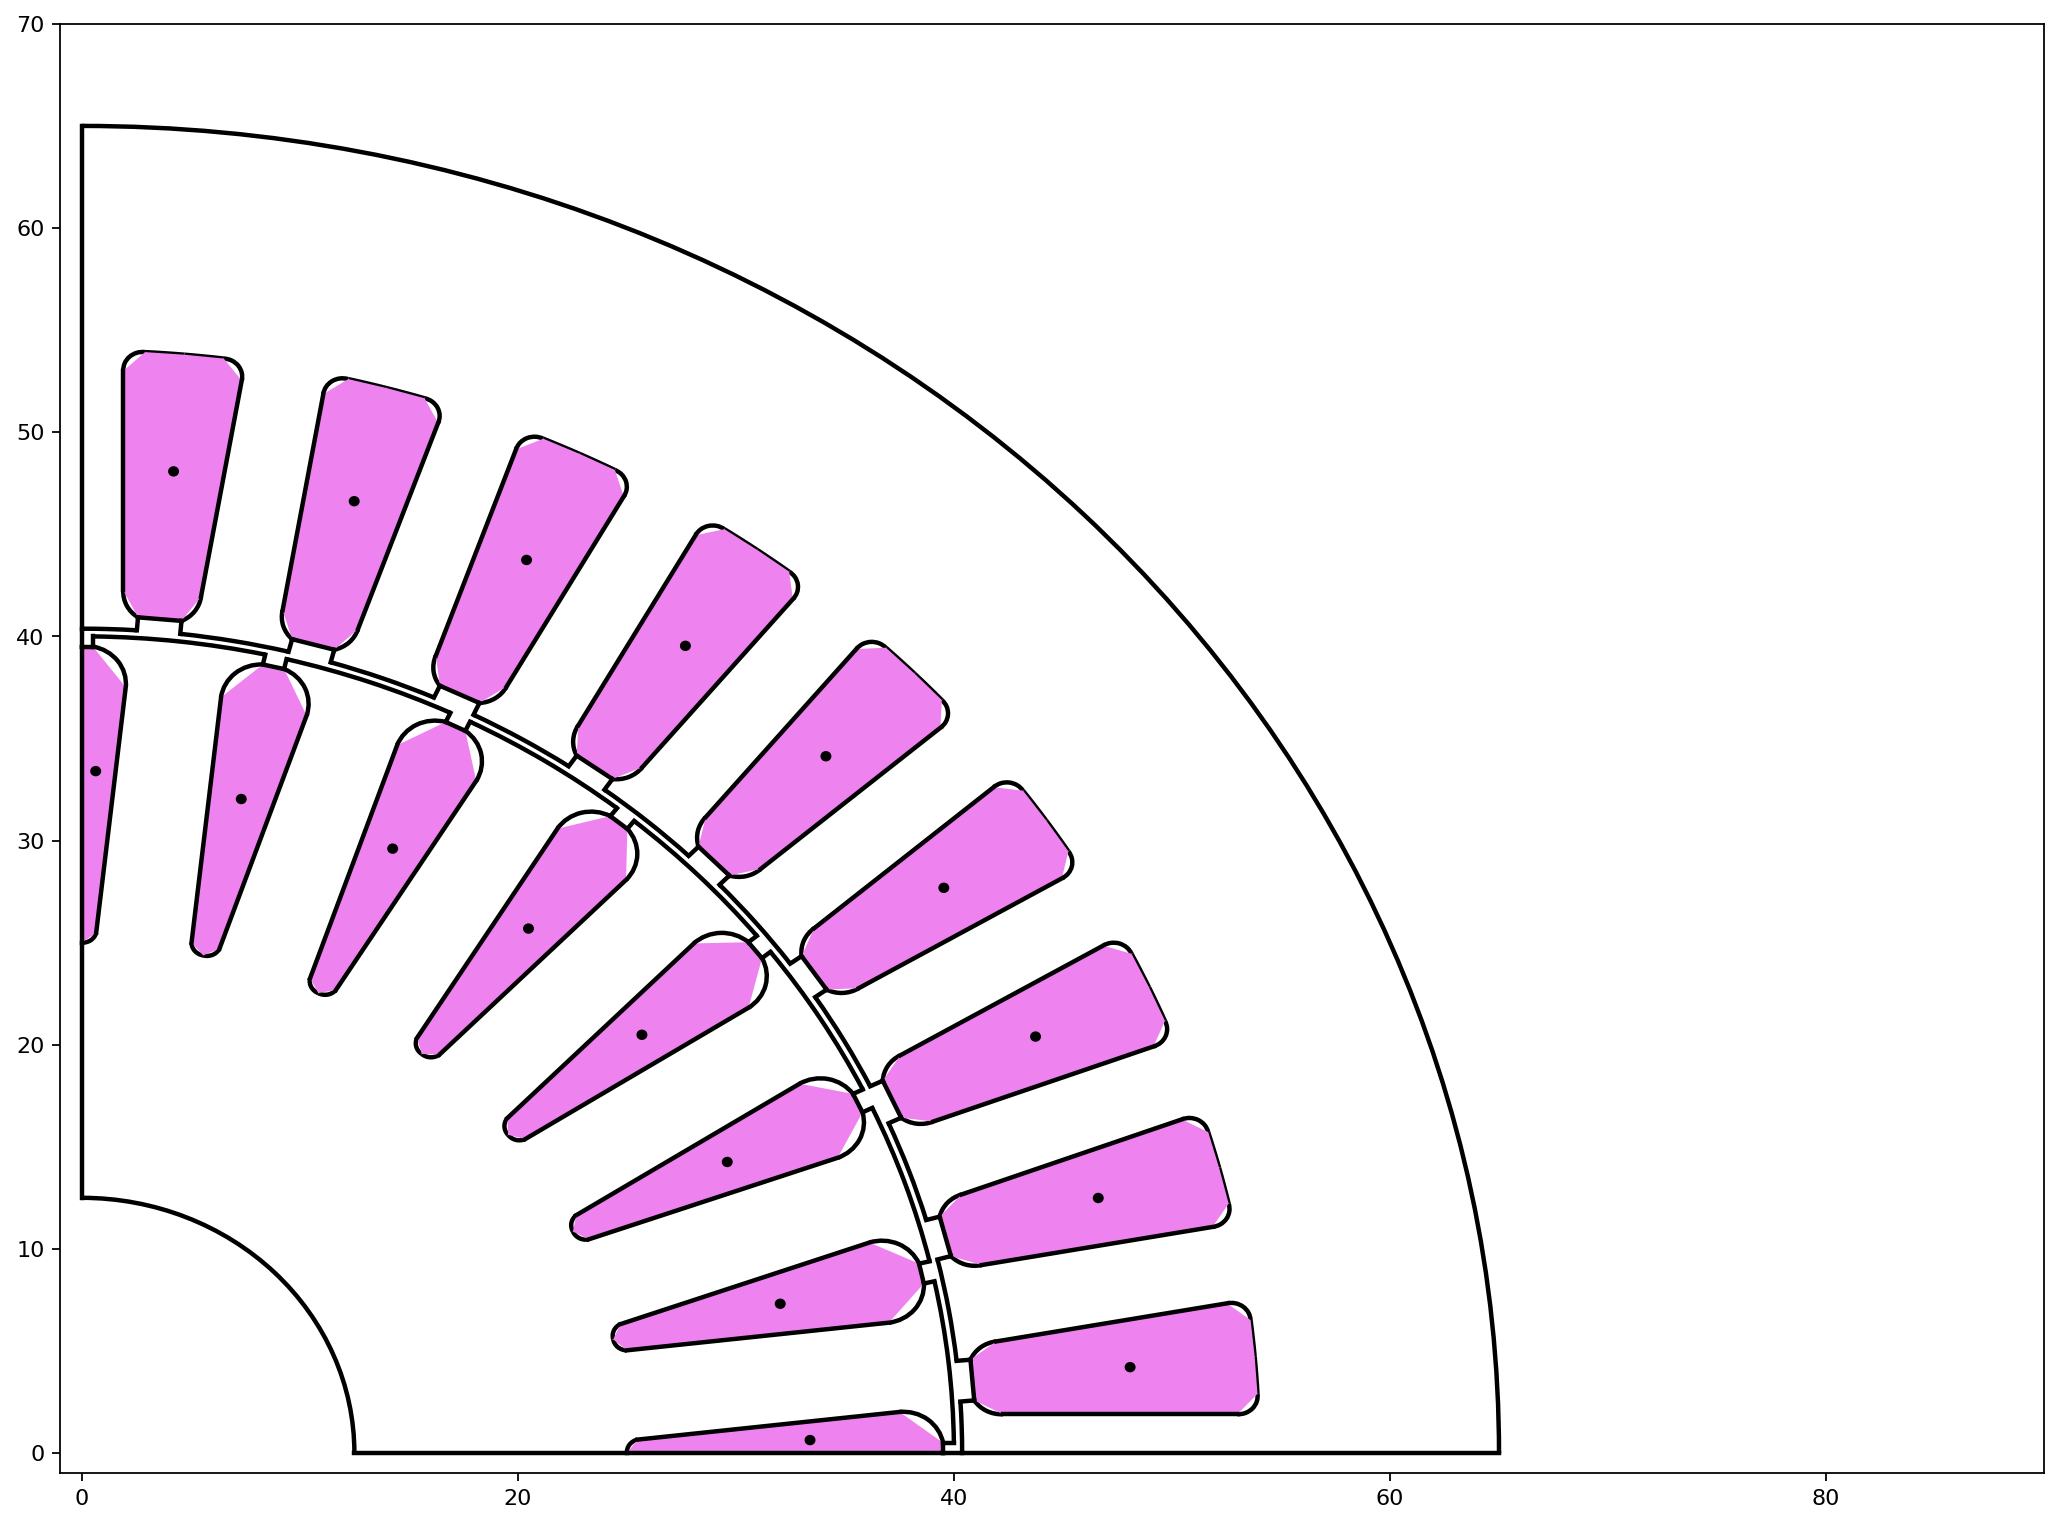

In [407]:
#draw image
plt.figure(figsize=[16,12], dpi=160)
plt.ylim(0,70)
plt.xlim(0,70)

linecolor = "black"
linewidth = 2

#settings for circles drawn

radius = 0.2
circ_color = "black"
#draw lines
for line in entities["lines"]:
    line_obj = plt.Line2D((line.start[0], line.end[0]), (line.start[1], line.end[1]), 
                          color=linecolor, linewidth=linewidth)
    plt.gca().add_patch(line_obj)

#draw arcs
for arc in entities["arcs"]:
    arc_obj = patch.Arc(arc.center, arc.radius*2, arc.radius*2, 
                        theta1 = arc.start_angle, theta2 = arc.end_angle, edgecolor=linecolor, 
                        linewidth=linewidth)
    plt.gca().add_patch(arc_obj)

#draw areas
for poly in drawcycle:
    plt.fill([point[0] for point in poly], [point[1] for point in poly], facecolor="violet")

#draw center of colored areas    
for poly, cords in center.items():
    circle_obj = patch.Circle(cords, radius=radius, color=circ_color)
    plt.gca().add_patch(circle_obj)
    
plt.axis([-1,90,-1,70])
plt.show()